In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Reshape,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from keras.layers import GlobalMaxPooling2D, Conv3D, MaxPooling3D, ConvLSTM2D, Add
from keras.models import Model
from keras.initializers import Constant
from keras.optimizers import SGD
from keras import regularizers
import tensorflow as tf

import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Text Model**

In [ ]:
MAX_UTTERANCE_LENGTH = 20
MAX_NUM_WORDS = 20000

In [ ]:
text = open("/content/drive/MyDrive/MELD_pickles/text_utterances.pickle","rb")
text_utterances = pickle.load(text)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\x97\x92\x98\x85\x91')
tokenizer.fit_on_texts(text_utterances)
text_sequences = tokenizer.texts_to_sequences(text_utterances)
data_text = pad_sequences(text_sequences, maxlen=MAX_UTTERANCE_LENGTH)

In [ ]:
data_text[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,  10,  22,  62,  39,   7,
       343,   4,  39,   7, 237, 343,   4], dtype=int32)

In [ ]:
data_text.shape 

(1102, 20)

In [ ]:
embedding_matrix = open("/content/drive/MyDrive/MELD_pickles/embedding.pickle","rb")
embedding_matrix = pickle.load(embedding_matrix)

In [ ]:
num_words = len(embedding_matrix)
EMBEDDING_DIM = embedding_matrix.shape[1]

In [ ]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_UTTERANCE_LENGTH,
                            trainable=False)

In [ ]:
input_text_ = Input(shape = (MAX_UTTERANCE_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(input_text_)
output_text_ = Conv1D(64, 5, activation='relu')(embedded_sequences)
output_text_ = MaxPooling1D(2)(output_text_)
output_text_ = Conv1D(100, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001))(output_text_)
output_text_ = GlobalMaxPooling1D()(output_text_) #as in paper 100D textual features

model_text = Model(inputs = input_text_, outputs = output_text_)
model_text.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 300)           444600    
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 100)            32100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                              

**Facial Recognition Model**

In [ ]:
pickle_frame = open("/content/drive/MyDrive/MELD_pickles/frame_float32.pickle","rb")
frames = pickle.load(pickle_frame)

frames = frames/255.0

(1102, 10, 84, 150, 3)


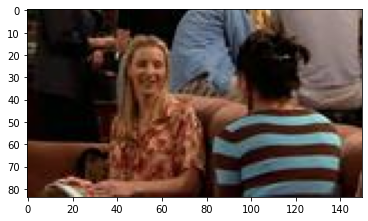

In [ ]:
plt.imshow(frames[663][0])
print(frames.shape)

In [ ]:
input_frame_ = Input(shape = (10, 84, 150, 3))

output_frame_ = ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   padding='valid', return_sequences=False)(input_frame_) 
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = MaxPooling2D((2, 2), strides = 2)(output_frame_)

output_frame_ = Conv2D(64, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(128, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(64, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Conv2D(32, kernel_size=(3, 3))(output_frame_)
output_frame_ = BatchNormalization()(output_frame_)
# output_frame_ = MaxPooling2D((2, 2))(output_frame_)

output_frame_ = Flatten()(output_frame_)

**Audio Model**

In [ ]:
pickle_audio_mfcc = open("/content/drive/MyDrive/MELD_pickles/audio_mfcc.pickle","rb")
audio_mfcc = pickle.load(pickle_audio_mfcc)

In [ ]:
audio_mfcc[0]

array([-2.5204980e+02,  9.8245911e+01, -1.0729630e+00,  1.6193819e+01,
       -3.3569479e+00,  1.5846486e+00, -2.2675459e+00, -7.8932703e-01,
       -1.0410025e+01,  8.8170147e+00, -6.5845890e+00, -9.5050734e-01,
       -1.1193515e+01, -1.2019171e+00, -4.9710588e+00, -5.1821032e+00,
       -1.3284195e+01, -1.0525883e+00, -9.3478098e+00,  9.1920823e-01,
       -4.9867902e+00, -7.1932149e-01, -3.6022828e+00,  4.7011280e+00,
       -2.4480112e+00,  3.1680945e-01, -3.9431455e+00,  5.2466769e+00,
       -3.2763915e+00,  2.1462993e-01, -9.4056110e+00, -4.3879204e+00,
       -4.5831275e+00,  3.2707655e+00, -2.7886453e+00,  1.6523506e-01,
       -2.6212423e+00, -1.1104983e+00, -4.0376935e+00, -8.1471580e-01],
      dtype=float32)

In [ ]:
audio_mfcc = audio_mfcc.reshape(1102, 10, 4)

In [ ]:
audio_mfcc.shape

(1102, 10, 4)

In [ ]:
input_audio_ = Input(shape = (10, 4))
output_audio_ = Conv1D(16, 3, activation='relu')(input_audio_)
output_audio_ = MaxPooling1D(2)(output_audio_)
output_audio_ = Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(output_audio_)
output_audio_ = MaxPooling1D(2)(output_audio_)
output_audio_ = Reshape((32,))(output_audio_)

**Concatenate Models**

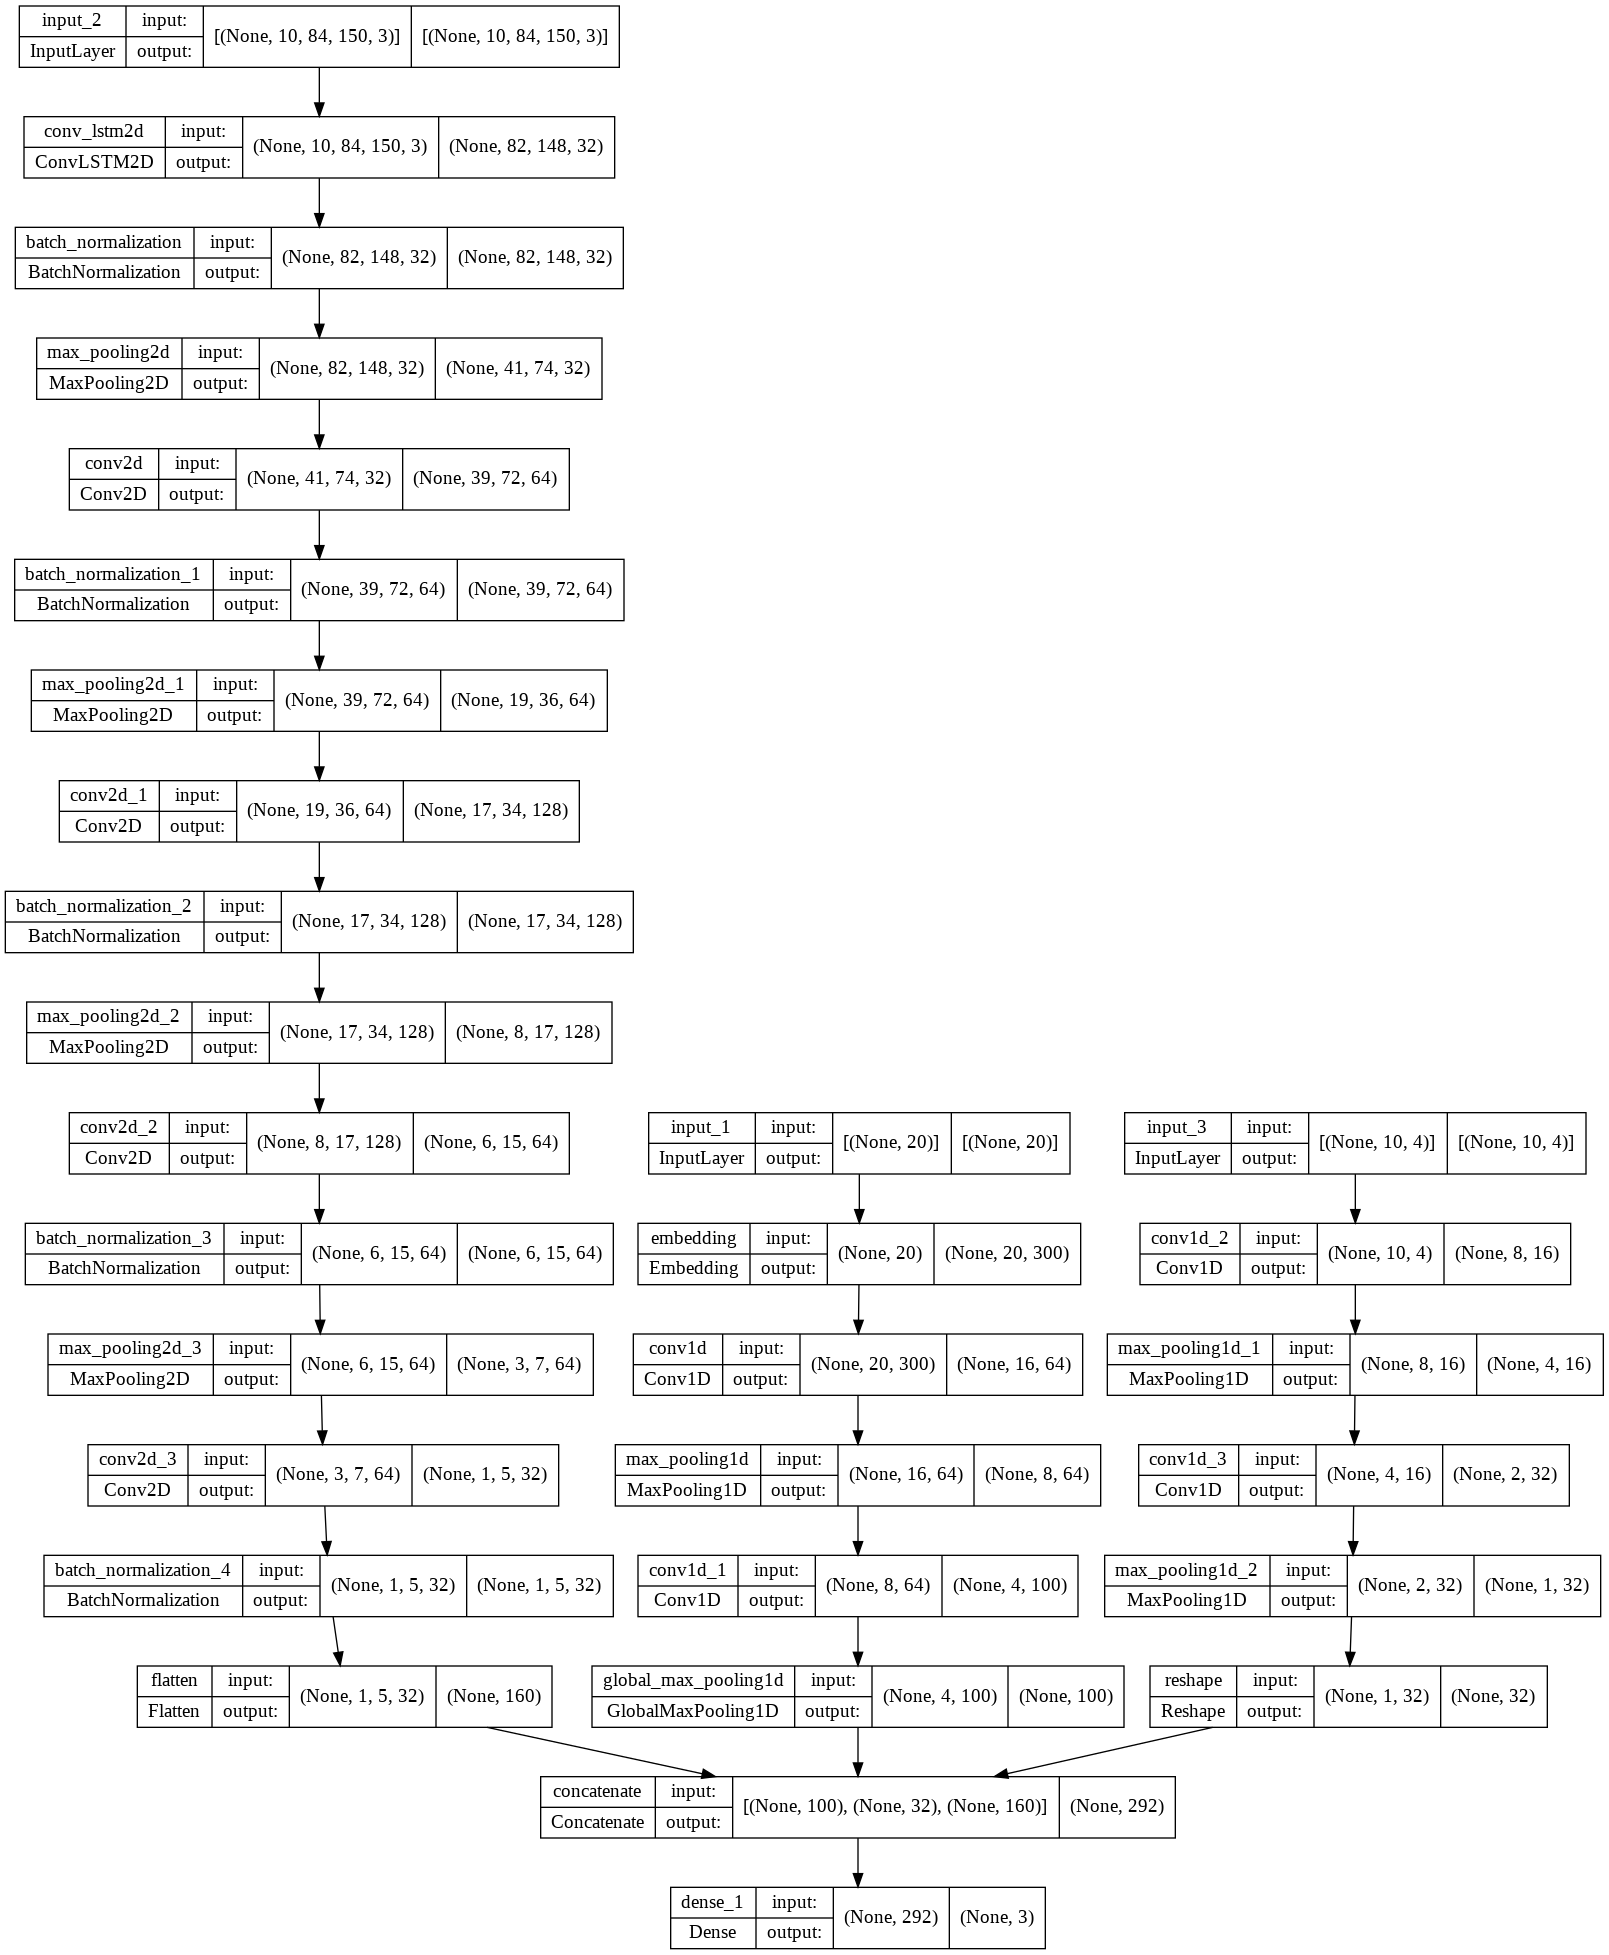

In [ ]:
concatenate = keras.layers.Concatenate()([output_text_, output_audio_, output_frame_])
emotions = Dense(7, activation='softmax')(concatenate)
model = Model(inputs=[input_text_, input_audio_, input_frame_], outputs=emotions)
tf.keras.utils.plot_model(model, to_file='test.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 84, 150  0           []                               
                                , 3)]                                                             
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 82, 148, 32)  40448       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 82, 148, 32)  128        ['conv_lstm2d[0][0]']            
 alization)                                                                                       
                                                                                            

In [ ]:
pickle_y = open("/content/drive/MyDrive/MELD_pickles/Y_float32.pickle","rb")
Y = pickle.load(pickle_y)

In [ ]:
Y_emotions = to_categorical(Y[:,0])

print(Y_emotions.shape)

(1102, 7)
(1102, 3)


In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [ ]:
# fit network
history = model.fit([data_text, audio_mfcc, frames], Y_emotions,
                    epochs = 5, 
                    batch_size=16,
                    validation_split=0.20)

Epoch 1/5
56/56 [==============================] - 61s 971ms/step - loss: 1.8728 - accuracy: 0.3973 - val_loss: 1.4904 - val_accuracy: 0.3620
Epoch 2/5
56/56 [==============================] - 53s 941ms/step - loss: 1.2683 - accuracy: 0.4858 - val_loss: 1.6392 - val_accuracy: 0.3167
Epoch 3/5
56/56 [==============================] - 53s 946ms/step - loss: 1.1828 - accuracy: 0.5585 - val_loss: 1.3303 - val_accuracy: 0.4706
Epoch 4/5
56/56 [==============================] - 53s 940ms/step - loss: 0.9302 - accuracy: 0.6890 - val_loss: 1.3765 - val_accuracy: 0.4932
Epoch 5/5
56/56 [==============================] - 53s 942ms/step - loss: 0.7050 - accuracy: 0.8411 - val_loss: 1.4553 - val_accuracy: 0.4661


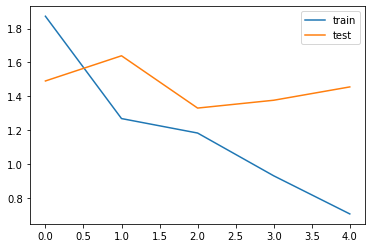

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

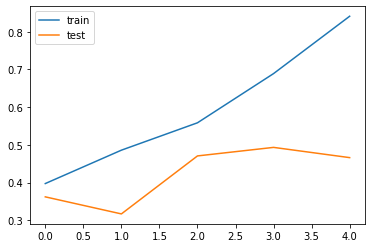

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()